# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Изучение данных из файла
Импортируем библиотеки, с которыми будем работать

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

import seaborn as sbn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Сохраняем данные в переменную `df`

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак:
* Exited — факт ухода клиента
 
Посмотрим общую информацию о данных и описательную статистику по каждому столбцу датафрейма.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


В таблице с данными о поведении клиентов и расторжении договоров с банком 10 000 строк и 14 столбцов. Заголовки не соответствуют правилу хорошего стиля. В столбце "Сколько лет человек является клиентом банка" есть пропущенные значения.

### Стиль заголовков

Приведем заголовки к написанию в нижнем регистре

In [5]:
df.columns = df.columns.str.lower()
df

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Переименуем в соответствии со змеиным стилем.

In [6]:
df = df.rename(columns={'rownumber': 'row_number', 
                        'customerid': 'customer_id',
                        'creditscore': 'credit_score',
                        'numofproducts': 'num_of_products',
                        'hascrcard': 'has_cr_card',
                        'isactivemember': 'is_active_member',
                        'estimatedsalary': 'estimated_salary'})
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Привели названия столбцов в  соответствие с хорошим стилем.

### Дубликаты и пропущенные значения

Первые три столбца таблицы не имеют существенного значения для нашего исследования, поэтому удалим их.

In [7]:
df = df.drop(['row_number','customer_id','surname'], axis=1)
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим датасет на наличие дубликатов.

In [8]:
df.duplicated().sum()

0

Дубликатов в таблице нет, теперь посмотрим на пропуски.

In [9]:
df.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

Пропущенные значения есть только в столбце "Сколько лет человек является клиентом банка", посмотрим уникальные значения этого столбца.

In [10]:
df['tenure'].value_counts().sort_values()

0.0     382
10.0    446
6.0     881
9.0     882
4.0     885
7.0     925
5.0     927
3.0     928
8.0     933
2.0     950
1.0     952
Name: tenure, dtype: int64

Клиенты банка пользуются услугами разное количество лет - максимум 10.
Пропущенные значения в столбце "Сколько лет человек является клиентом банка" могут быть следствием ошибок сбора или хранения данных. У нас нет инструментов, чтобы достоверно восстановить пропущенные значения и пропуски составляют всего 9%, поэтому исключим эти строки из анализа.

In [11]:
df = df.dropna(subset=['tenure'])
df.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### Мультиколлинеарность

Проведем корреляционный анализ факторов, для этого посчитаем коэффициент корреляции Пирсона.

In [12]:
corr_matrix = df.corr().round(2)
corr_matrix

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.00,-0.00,-0.00,0.00,0.01,-0.00,0.03,0.01,-0.02
age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.08,-0.01,0.28
tenure,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
balance,0.00,0.03,-0.01,1.00,-0.30,-0.02,-0.00,0.01,0.12
num_of_products,0.01,-0.03,0.01,-0.30,1.00,0.01,0.01,0.01,-0.05
has_cr_card,-0.00,-0.01,0.03,-0.02,0.01,1.00,-0.01,-0.01,-0.01
is_active_member,0.03,0.08,-0.03,-0.00,0.01,-0.01,1.00,-0.02,-0.16
estimated_salary,0.01,-0.01,0.01,0.01,0.01,-0.01,-0.02,1.00,0.02
exited,-0.02,0.28,-0.02,0.12,-0.05,-0.01,-0.16,0.02,1.00


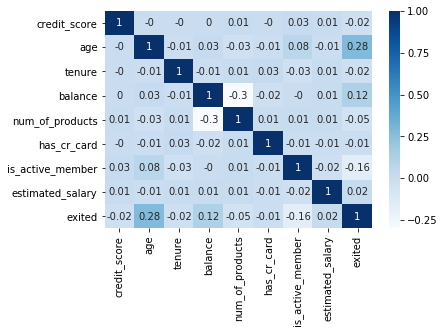

In [13]:
sbn.heatmap(corr_matrix, 
            annot=True, 
            cmap='Blues')
plt.show()

Наблюдаем слабую положительную корреляцию возраста и баланса на счёте с фактом ухода клиента из банка. Оставляем все признаки в работе.

### Вывод

В ходе подготовки данных мы обнаружили несколько проблем:

- столбцы с бесполезной информацией,
- нарушения в стиле заголовков,
- пропущенные значения.


Мы исправили заголовки, чтобы упростить работу с таблицей, удалили лишние столбцы. 

Удалили пропущенные значения в столбце "Сколько лет человек является клиентом банка", поскольку восстановить их достоверно невозможно.

Теперь данные готовы к дальнейшему анализу.

## Исследование задачи

### Дамми-ловушка

Признаки `'geography'` и `'gender'` - категориальные. Чтобы избежать дамми-ловушки, преобразуем их в числовые.

In [14]:
df['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

In [15]:
df['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

In [16]:
df=pd.get_dummies(df, drop_first=True)
df.head().T

,0,1,2,3,4
credit_score,619.00,608.00,502.00,699.00,850.00
age,42.00,41.00,42.00,39.00,43.00
tenure,2.00,1.00,8.00,1.00,2.00
balance,0.00,83807.86,159660.80,0.00,125510.82
num_of_products,1.00,1.00,3.00,2.00,1.00
has_cr_card,1.00,0.00,1.00,0.00,1.00
is_active_member,1.00,1.00,0.00,0.00,1.00
estimated_salary,101348.88,112542.58,113931.57,93826.63,79084.10
exited,1.00,0.00,1.00,0.00,0.00
geography_Germany,0.00,0.00,0.00,0.00,0.00


После преобразования в таблице добавились 3 столбца.

### Разделение исходных данных на выборки
Нам нужно построить модель для задачи классификации. Для этого разделим исходные данные на выборки.

Для начала выделим в исходных данных:
* **признаки**: credit_score, age, tenure, balance, num_of_products, has_cr_card, is_active_member, estimated_salary, geography_Germany, geography_Spain, gender_Male 	 
* **целевой признак**: exited

In [17]:
features = df.drop(['exited'], axis=1)
target = df['exited']

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки)

In [18]:
df_train, df_valid = train_test_split(df, train_size=0.6, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

print('Размер обучающей выборки', df_train.shape)
print('Размер валидационной выборки', df_valid.shape)
print('Размер тестовой выборки', df_test.shape)

Размер обучающей выборки (5454, 12)
Размер валидационной выборки (1818, 12)
Размер тестовой выборки (1819, 12)


Составим таблицы признаков и целевого признака для каждой выборки.

In [19]:
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

Мы разделили данные по принципу 60/20/20:

1. обучение проведем на данных `df_train`;
2. проверку модели - на данных `df_valid`;
3. лучшую модель по результатам проверки применим на данных `df_test`.

Приведём численные признаки к одному масштабу.

In [20]:
numeric = ['credit_score', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(5454, 11)
(1818, 11)
(1819, 11)


### Баланс классов


Проверим насколько сбалансированны данные.

0    0.796062
1    0.203938
Name: exited, dtype: float64


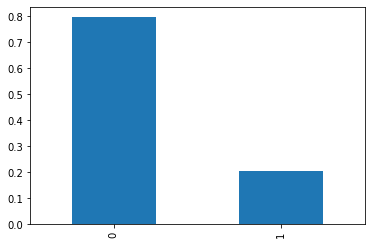

In [21]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

In [22]:
target.value_counts()

0    7237
1    1854
Name: exited, dtype: int64

Мы наблюдаем дисбаланс классов - клиенты уходят в 20% случаев (отрицательный класс больше положительного в 4 раза).

### Модель решающего дерева

Изучим модели без на несбалансированных данных. Начнем с модели решающего дерева DecisionTreeClassifier. Изменим в цикле гиперпараметр `max_depth`. Критерием проверки качества модели будет `F1` и `AUC-ROC`.

In [23]:
%%time

best_depth = 0
best_f1 = 0
best_auc_roc = 0

for depth in range(1, 10):
    # инициализируем модель решающего дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # обучаем модель
    model.fit(features_train, target_train)
    
    # находим предсказания на валидационной выборке
    predictions_valid = model.predict(features_valid)
    # находим метрику f1
    f1 = f1_score(target_valid, predictions_valid)
    
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1
        # находим вероятности класса "1"
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        # находим метрику auc_roc
        best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                          
fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая глубина дерева', best_depth)
print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print()

Лучшая глубина дерева 7
Лучшая метрика F1 0.5764331210191083
Лучшая метрика AUC-ROC 0.8346049843812412

CPU times: user 204 ms, sys: 7.04 ms, total: 212 ms
Wall time: 226 ms


Модель решающего дерева на несбалансированных данных с метрикой F1 = 0,5764 не удовлетворяет условиям задачи. Посмотрим на модель случайного леса.

### Модель случайного леса 

1. Инициируем модель случайного леса RandomForestClassifier

2. Выделим гиперпараметры для настройки модели:
 * `n_estimators` - число «деревьев» в «случайном лесу»;
 * `max_depth` - максимальная глубина деревьев;
 * `min_samples_leaf` - минимальное количество объектов в листьях;


3. Критерием проверки качества модели будет точность `F1` и `AUC-ROC`.

In [24]:
%%time

best_model = None
best_f1 = 0
best_est = 0
best_depth = 0
best_min_samples_leaf = 0
best_auc_roc = 0

# количество деревьев: от 10 до 50 с шагом 10
for est in range(10, 51, 10):
    # максимальная глубина от 1 до 10
    for depth in range (1, 11):
        # минимальное число объектов в листьях от 1 до 10
        for min_samples_leaf in range (1, 11):
            # инициализируем модель случайного леса
            model = RandomForestClassifier(random_state=12345, 
                                           n_estimators=est, 
                                           max_depth=depth, 
                                           min_samples_leaf= min_samples_leaf) 
            
            # обучаем модель на тренировочной выборке
            model.fit(features_train, target_train) 
            
            # находим предсказания на валидационной выборке
            predictions_valid = model.predict(features_valid) 
            
            # проверяем качество модели на валидационной выборке
            f1 = f1_score(target_valid, predictions_valid)
                      
            if f1 > best_f1:
                best_model = model 
                best_f1 = f1
                best_est = est
                best_depth = depth
                best_min_samples_leaf = min_samples_leaf
                # находим вероятности класса "1"
                probabilities_valid = model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                # находим метрику auc_roc
                best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                                               
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print('Количество деревьев:', best_est) 
print('Максимальная глубина:', best_depth)
print('Минимальное число объектов в листьях:', best_min_samples_leaf)
print()

Лучшая метрика F1 0.5945945945945946
Лучшая метрика AUC-ROC 0.8652286118724655
Количество деревьев: 10
Максимальная глубина: 8
Минимальное число объектов в листьях: 10

CPU times: user 1min, sys: 185 ms, total: 1min 1s
Wall time: 1min 1s


Метрика F1 модели случайного леса выше на 1,82% по сравнению с моделью решающего дерева. 

### Модель логистической регрессии
Инициализируем модель логистической регрессии с параметром `random_state=12345`

In [25]:
%%time

model = LogisticRegression(random_state=12345, solver='liblinear') 

# обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# получим метрику качества модели на валидационной выборке
f1 = f1_score(target_valid, predictions_valid)

# находим вероятности класса "1"
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
# находим метрику auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

fpr_regr, tpr_regr, thresholds = roc_curve(target_valid, probabilities_one_valid)

print("F1 модели логистической регрессии на валидационной выборке:", f1)
print("AUC-ROC модели логистической регрессии на валидационной выборке:", auc_roc)
print()

F1 модели логистической регрессии на валидационной выборке: 0.5609756097560976
AUC-ROC модели логистической регрессии на валидационной выборке: 0.7735767785780947

CPU times: user 30.7 ms, sys: 16 ms, total: 46.6 ms
Wall time: 19.6 ms


Самая низкая метрика F1 у модели логистической регрессии.

Построим ROC-кривую для моделей по несбалансированным данным. По оси Х - доля ложных предсказываний, по оси У - для верных предсказаний.

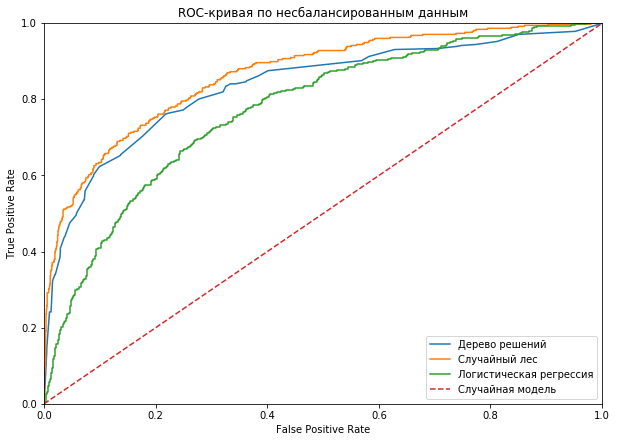

In [26]:
plt.figure(figsize=[10,7])
plt.plot(fpr_tree, tpr_tree, label = 'Дерево решений')
plt.plot(fpr_forest, tpr_forest, label = 'Случайный лес')
plt.plot(fpr_regr, tpr_regr, label = 'Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Случайная модель')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('ROC-кривая по несбалансированным данным')
plt.legend()

plt.show()

Полученные результаты говорят о том, что лучшая метрика F1=0,5946 и AUC-ROC=0,8652 у модели случайного леса.

### Вывод

Проведенный анализ показывает дисбаланс классов в соотношении 4:1, что сказывается на качестве моделей. Наименее устойчива к дисбалансу модель логистической регресси. Посмотрим как изменятся метрики, учитывая дисбаланс классов.

## Борьба с дисбалансом

Первый метод борьбы с дисбалансом - взвешивание классов, применим его на моделях, посмотрим результаты.

### Взвешивание классов

In [27]:
%%time

best_depth = 0
best_f1 = 0
best_auc_roc = 0

for depth in range(1, 10):
    # инициализируем модель решающего дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    
    # обучаем модель
    model.fit(features_train, target_train)
    
    # находим предсказания на валидационной выборке
    predictions_valid = model.predict(features_valid)
    # находим метрику f1
    f1 = f1_score(target_valid, predictions_valid)
    
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1
        # находим вероятности класса "1"
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        # находим метрику auc_roc
        best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                          
fpr_tree_cw, tpr_tree_cw, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая глубина дерева', best_depth)
print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print()

Лучшая глубина дерева 5
Лучшая метрика F1 0.5735449735449736
Лучшая метрика AUC-ROC 0.8396523192522141

CPU times: user 154 ms, sys: 3.98 ms, total: 158 ms
Wall time: 165 ms


In [28]:
%%time

best_model = None
best_f1 = 0
best_est = 0
best_depth = 0
best_min_samples_leaf = 0
best_auc_roc = 0

# количество деревьев: от 10 до 50 с шагом 10
for est in range(10, 51, 10):
    # максимальная глубина от 1 до 10
    for depth in range (1, 11):
        # минимальное число объектов в листьях от 1 до 10
        for min_samples_leaf in range (1, 11):
            # инициализируем модель случайного леса
            model = RandomForestClassifier(random_state=12345, 
                                           n_estimators=est, 
                                           max_depth=depth, 
                                           min_samples_leaf= min_samples_leaf,
                                           class_weight='balanced') 
            
            # обучаем модель на тренировочной выборке
            model.fit(features_train, target_train) 
            
            # находим предсказания на валидационной выборке
            predictions_valid = model.predict(features_valid)
    
            # проверяем качество модели на валидационной выборке
            f1 = f1_score(target_valid, predictions_valid)
                      
            if f1 > best_f1:
                best_model = model 
                best_f1 = f1
                best_est = est
                best_depth = depth
                best_min_samples_leaf = min_samples_leaf
                # находим вероятности класса "1"
                probabilities_valid = model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                # находим метрику auc_roc
                best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                                               
fpr_forest_cw, tpr_forest_cw, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print('Количество деревьев:', best_est) 
print('Максимальная глубина:', best_depth)
print('Минимальное число объектов в листьях:', best_min_samples_leaf)
print()

Лучшая метрика F1 0.6488372093023255
Лучшая метрика AUC-ROC 0.8709579443983236
Количество деревьев: 30
Максимальная глубина: 8
Минимальное число объектов в листьях: 3

CPU times: user 1min, sys: 271 ms, total: 1min
Wall time: 1min 1s


In [29]:
%%time

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 

# обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

predictions_valid = model.predict(features_valid)

# получим метрику качества модели на валидационной выборке
f1 = f1_score(target_valid, predictions_valid)

# находим вероятности класса "1"
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
# находим метрику auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

fpr_regr_cw, tpr_regr_cw, thresholds = roc_curve(target_valid, probabilities_one_valid)

print("F1 модели логистической регрессии на валидационной выборке:", f1)
print("AUC-ROC модели логистической регрессии на валидационной выборке:", auc_roc)
print()

F1 модели логистической регрессии на валидационной выборке: 0.5092592592592593
AUC-ROC модели логистической регрессии на валидационной выборке: 0.7777681649753247

CPU times: user 119 ms, sys: 148 ms, total: 267 ms
Wall time: 288 ms


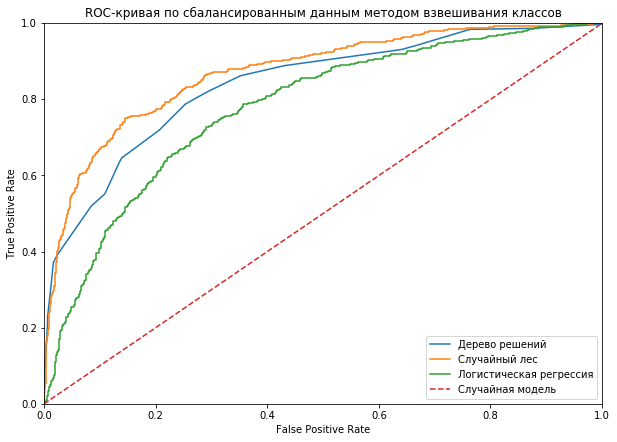

In [30]:
plt.figure(figsize=[10,7])
plt.plot(fpr_tree_cw, tpr_tree_cw, label = 'Дерево решений')
plt.plot(fpr_forest_cw, tpr_forest_cw, label = 'Случайный лес')
plt.plot(fpr_regr_cw, tpr_regr_cw, label = 'Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Случайная модель')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('ROC-кривая по сбалансированным данным методом взвешивания классов')
plt.legend()

plt.show()

По результатам взвешивания классов улучшилась мера F1 для модели случайного леса, а для моделей решающего дерева и логистической регерссии - ухудшилась. У модели случайного леса метрики F1 = 0,6488 и AUC-ROC = 0,871 при количестве деревьев = 30, максимальной глубине = 10 и минимальном числе объектов в листьях = 3.

### Увеличение выборки

Увеличим в 4 раза объекты редкого класса методом "upsampling".

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts()

1    4504
0    4328
Name: exited, dtype: int64

In [32]:
%%time

best_depth = 0
best_f1 = 0
best_auc_roc = 0

for depth in range(1, 10):
    # инициализируем модель решающего дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # обучаем модель
    model.fit(features_upsampled, target_upsampled) 

    # находим предсказания на валидационной выборке
    predictions_valid = model.predict(features_valid)
    
    # находим метрику f1
    f1 = f1_score(target_valid, predictions_valid)
    
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1
        # находим вероятности класса "1"
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        # находим метрику auc_roc
        best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                          
fpr_tree_us, tpr_tree_us, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая глубина дерева', best_depth)
print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print()

Лучшая глубина дерева 5
Лучшая метрика F1 0.5735449735449736
Лучшая метрика AUC-ROC 0.8396523192522141

CPU times: user 186 ms, sys: 8.03 ms, total: 194 ms
Wall time: 195 ms


In [34]:
%%time

best_model = None
best_f1 = 0
best_est = 0
best_depth = 0
best_min_samples_leaf = 0
best_auc_roc = 0

# количество деревьев: от 10 до 50 с шагом 10
for est in range(10, 51, 10):
    # максимальная глубина от 1 до 10
    for depth in range (1, 11):
        # минимальное число объектов в листьях от 1 до 10
        for min_samples_leaf in range (1, 11):
            # инициализируем модель случайного леса
            model = RandomForestClassifier(random_state=12345, 
                                           n_estimators=est, 
                                           max_depth=depth, 
                                           min_samples_leaf= min_samples_leaf) 
            
            # обучаем модель на тренировочной выборке
            model.fit(features_upsampled, target_upsampled) 
            
            # находим предсказания на валидационной выборке
            predictions_valid = model.predict(features_valid)
            
            # проверяем качество модели на валидационной выборке
            f1 = f1_score(target_valid, predictions_valid)
                      
            if f1 > best_f1:
                best_model = model 
                best_f1 = f1
                best_est = est
                best_depth = depth
                best_min_samples_leaf = min_samples_leaf
                # находим вероятности класса "1"
                probabilities_valid = model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                # находим метрику auc_roc
                best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                                               
fpr_forest_us, tpr_forest_us, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print('Количество деревьев:', best_est) 
print('Максимальная глубина:', best_depth)
print('Минимальное число объектов в листьях:', best_min_samples_leaf)
print()

Лучшая метрика F1 0.6445714285714287
Лучшая метрика AUC-ROC 0.8714788764801926
Количество деревьев: 50
Максимальная глубина: 10
Минимальное число объектов в листьях: 5

CPU times: user 1min 31s, sys: 363 ms, total: 1min 31s
Wall time: 1min 32s


In [35]:
%%time

model = LogisticRegression(random_state=12345, solver='liblinear') 

# обучим модель на тренировочной выборке
model.fit(features_upsampled, target_upsampled) 

# находим предсказания на валидационной выборке
predictions_valid = model.predict(features_valid)

# получим метрику качества модели на валидационной выборке
f1 = f1_score(target_valid, predictions_valid)

# находим вероятности класса "1"
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
# находим метрику auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

fpr_regr_us, tpr_regr_us, thresholds = roc_curve(target_valid, probabilities_one_valid)

print("F1 модели логистической регрессии на валидационной выборке:", f1)
print("AUC-ROC модели логистической регрессии на валидационной выборке:", auc_roc)
print()

F1 модели логистической регрессии на валидационной выборке: 0.5072463768115941
AUC-ROC модели логистической регрессии на валидационной выборке: 0.7778252282069076

CPU times: user 54.5 ms, sys: 28.2 ms, total: 82.6 ms
Wall time: 56.8 ms


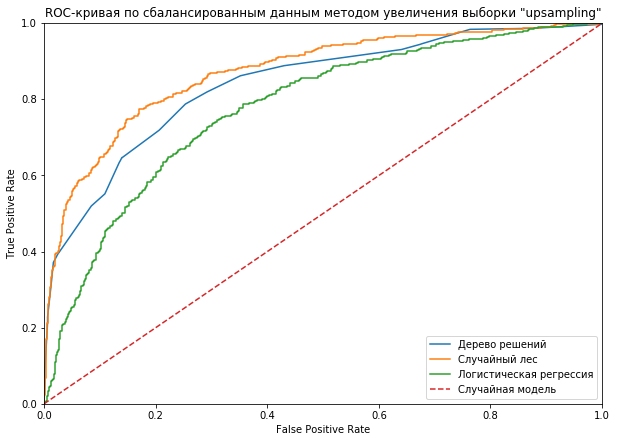

In [36]:
plt.figure(figsize=[10,7])
plt.plot(fpr_tree_us, tpr_tree_us, label = 'Дерево решений')
plt.plot(fpr_forest_us, tpr_forest_us, label = 'Случайный лес')
plt.plot(fpr_regr_us, tpr_regr_us, label = 'Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Случайная модель')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('ROC-кривая по сбалансированным данным методом увеличения выборки "upsampling"')
plt.legend()

plt.show()

По результатам метода "upsampling" улучшилась мера F1 для модели случайного леса, а для моделей решающего дерева и логистической регерссии - ухудшилась по сравнению с несбалансированными данными. У модели случайного леса метрики F1 = 0,6446 и AUC-ROC = 0,8715, что почти не отличается от результатов метода "взвешивание классов".

### Уменьшение выборки

Уменьшим в 4 раза объекты отрицательного класса методом "downsampling".

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345), features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345), target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

target_downsampled.value_counts()

1    1126
0    1082
Name: exited, dtype: int64

In [38]:
%%time

best_depth = 0
best_f1 = 0
best_auc_roc = 0

for depth in range(1, 10):
    # инициализируем модель решающего дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # обучаем модель
    model.fit(features_downsampled, target_downsampled) 

    # находим предсказания на валидационной выборке
    predictions_valid = model.predict(features_valid)
    
    # находим метрику f1
    f1 = f1_score(target_valid, predictions_valid)
    
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1
        # находим вероятности класса "1"
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        # находим метрику auc_roc
        best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                          
fpr_tree_ds, tpr_tree_ds, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая глубина дерева', best_depth)
print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print()

Лучшая глубина дерева 6
Лучшая метрика F1 0.5636704119850188
Лучшая метрика AUC-ROC 0.8343500405885245

CPU times: user 118 ms, sys: 12 µs, total: 118 ms
Wall time: 124 ms


In [39]:
%%time

best_model = None
best_f1 = 0
best_est = 0
best_depth = 0
best_min_samples_leaf = 0
best_auc_roc = 0

# количество деревьев: от 10 до 50 с шагом 10
for est in range(10, 51, 10):
    # максимальная глубина от 1 до 10
    for depth in range (1, 11):
        # минимальное число объектов в листьях от 1 до 10
        for min_samples_leaf in range (1, 11):
            # инициализируем модель случайного леса
            model = RandomForestClassifier(random_state=12345, 
                                           n_estimators=est, 
                                           max_depth=depth, 
                                           min_samples_leaf= min_samples_leaf) 
            
            # обучаем модель на тренировочной выборке
            model.fit(features_downsampled, target_downsampled) 
            
            # находим предсказания на валидационной выборке
            predictions_valid = model.predict(features_valid)
            
            # проверяем качество модели на валидационной выборке
            f1 = f1_score(target_valid, predictions_valid)
                      
            if f1 > best_f1:
                best_model = model 
                best_f1 = f1
                best_est = est
                best_depth = depth
                best_min_samples_leaf = min_samples_leaf
                # находим вероятности класса "1"
                probabilities_valid = model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                # находим метрику auc_roc
                best_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                                               
fpr_forest_ds, tpr_forest_ds, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('Лучшая метрика F1', best_f1)
print('Лучшая метрика AUC-ROC', best_auc_roc)
print('Количество деревьев:', best_est) 
print('Максимальная глубина:', best_depth)
print('Минимальное число объектов в листьях:', best_min_samples_leaf)
print()

Лучшая метрика F1 0.6072874493927125
Лучшая метрика AUC-ROC 0.8653234104668692
Количество деревьев: 40
Максимальная глубина: 8
Минимальное число объектов в листьях: 1

CPU times: user 38.4 s, sys: 248 ms, total: 38.7 s
Wall time: 38.9 s


In [40]:
%%time

model = LogisticRegression(random_state=12345, solver='liblinear') 

# обучим модель на тренировочной выборке
model.fit(features_downsampled, target_downsampled) 

# находим предсказания на валидационной выборке
predictions_valid = model.predict(features_valid)

# получим метрику качества модели на валидационной выборке
f1 = f1_score(target_valid, predictions_valid)

# находим вероятности класса "1"
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
# находим метрику auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

fpr_regr_ds, tpr_regr_ds, thresholds = roc_curve(target_valid, probabilities_one_valid)

print("F1 модели логистической регрессии на валидационной выборке:", f1)
print("AUC-ROC модели логистической регрессии на валидационной выборке:", auc_roc)
print()

F1 модели логистической регрессии на валидационной выборке: 0.5044883303411131
AUC-ROC модели логистической регрессии на валидационной выборке: 0.7770152984683124

CPU times: user 18.9 ms, sys: 51.8 ms, total: 70.7 ms
Wall time: 15.9 ms


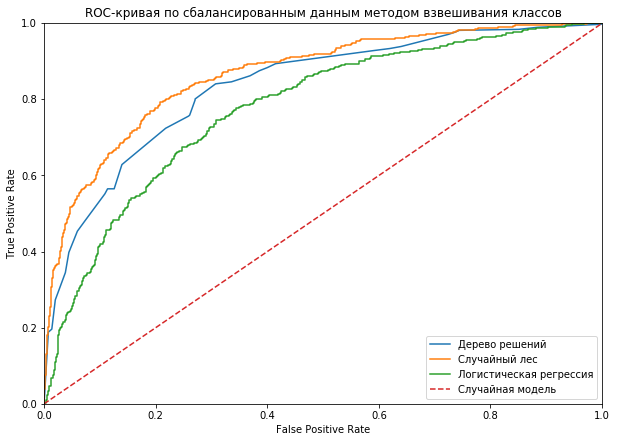

In [41]:
plt.figure(figsize=[10,7])
plt.plot(fpr_tree_ds, tpr_tree_ds, label = 'Дерево решений')
plt.plot(fpr_forest_ds, tpr_forest_ds, label = 'Случайный лес')
plt.plot(fpr_regr_ds, tpr_regr_ds, label = 'Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Случайная модель')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('ROC-кривая по сбалансированным данным методом взвешивания классов')
plt.legend()

plt.show()

По результатам метода "downsampling" улучшилась мера F1 для модели случайного леса, а для моделей решающего дерева и логистической регерссии - ухудшилась по сравнению с несбалансированными данными. У модели случайного леса метрики F1 = 0,6073 и AUC-ROC = 0,8653.

### Вывод
Значительное увеличение метрик F1 и AUC-ROC дают методы взвешивания классов и "upsampling" положительного класса. Наилучший результат для модели решающего дерева получается при взвешивании классов, при этом метрика F1 = 0,6488 удовлетворяет условиям задачи.

## Тестирование модели

Протестируем модель случайного леса со следующими параметрами:
* n_estimators = 30
* max_depth = 8
* min_samples_leaf = 3

Для учета дисбаланса применим метод взвешивания классов.

In [42]:
%%time
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=8, min_samples_leaf=3, class_weight='balanced') 
            
# обучаем модель на тренировочной выборке
model.fit(features_train, target_train) 
            
# находим предсказания на тестовой выборке
predictions_test = model.predict(features_test)
    
# проверяем качество модели на тестовой выборке
f1 = f1_score(target_test, predictions_test)
# находим вероятности класса "1"
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
# находим метрику auc_roc
auc_roc = roc_auc_score(target_test, probabilities_one_test)

fpr_forest_test, tpr_forest_test, thresholds = roc_curve(target_test, probabilities_one_test)
                                               
print('Метрика F1', f1)
print('Метрика AUC-ROC', auc_roc)

print()

Метрика F1 0.6084788029925187
Метрика AUC-ROC 0.8568201401988867

CPU times: user 168 ms, sys: 4 ms, total: 172 ms
Wall time: 178 ms


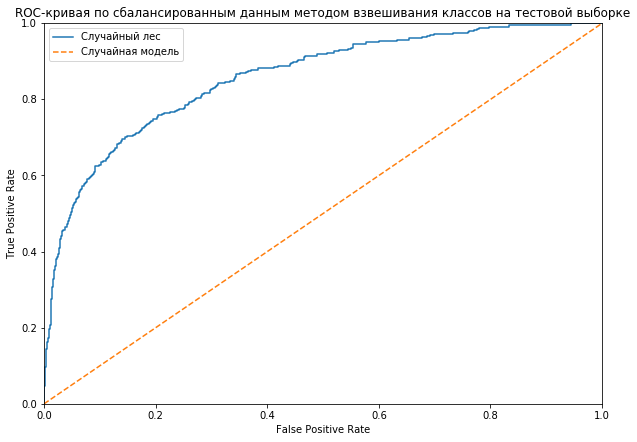

In [43]:
plt.figure(figsize=[10,7])
plt.plot(fpr_forest_test, tpr_forest_test, label = 'Случайный лес')
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Случайная модель')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('ROC-кривая по сбалансированным данным методом взвешивания классов на тестовой выборке')
plt.legend()

plt.show()

Метрика F1 модели случайного леса на сбалансированных данных на тестовой выборке составляет 0,6085. По условиям задачи необходмая метрика F1 должна быть не меньше 0,59. При этом полученная метрика на тестовой выборке меньше на 4%.

## Общий вывод

Объект нашего исследования - исторические данные о поведении клиентов и расторжении договоров с банком.

Предобработка данных обнаружила 3 проблемы:
1. столбцы с бесполезной информацией,
2. нарушения в стиле заголовков,
3. пропущенные значения.

Самые критичные ошибки данных мы исправили:
* привели названия столбцов к нижнему регистру и написанию в змеином стиле, 
* удалили пропущенные значения и ненужные столбцы.

Сильной взаимосвязи между признаками не выявили.

Для решения поставленной задачи мы разделили исходные данные на три выборки:
1. обучающую,
2. валидационную,
3. тестовую.

Исследовали три модели классификации сначала на несбалансированных данных, затем на сбалансированных:
* Дерево решений,
* Случайный лес,
* Логистическая регрессия.

Дисбаланс классов исправили тремя методами:
1. Взвешивание классов,
2. Upsampling,
3. Downsampling

Наилучшие результаты получили для модели случайного леса со взвешенными классами, проверили модель на тестовой выборке и получили необходимые метрики F1 = 0.6085 и AUC-ROC = 0,8568.